# Dynamic and non-dynamic solvers

You can choose between a `solvers.CalibrationFreeSolver()` (which does not calibrate the output-scale), a `solvers.MLESolver()` (which calibrates a global output scale via quasi-maximum-likelihood-estimation), and a `solvers.DynamicSolver()`, which calibrates a time-varying, piecewise constant output-scale via "local' quasi-maximum-likelihood estimation, similar to how ODE solver estimate local errors.

But are these good for?
In short: choose a `DynamicSolver` if your ODE output-scale varies quite strongly, and choose an `MLESolver` otherwise.

For example, consider the numerical solution of a linear ODE with fixed steps:

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, solvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [3]:
f, u0, (t0, t1), f_args = ivps.affine_independent(initial_values=(1.0,), a=2.0)


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

In [4]:
num_derivatives = 1

implementation = recipes.DenseTS1.from_params(
    ode_shape=(1,), num_derivatives=num_derivatives
)
strategy = filters.Filter(implementation=implementation)

dynamic = solvers.DynamicSolver(strategy=strategy)
mle = solvers.MLESolver(strategy=strategy)

In [5]:
t0, t1 = 0.0, 3.0
num_pts = 200

ts = jnp.linspace(t0, t1, num=num_pts, endpoint=True)
solution_dynamic = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=dynamic, parameters=f_args
)
solution_mle = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=mle, parameters=f_args
)

Plot the solution.

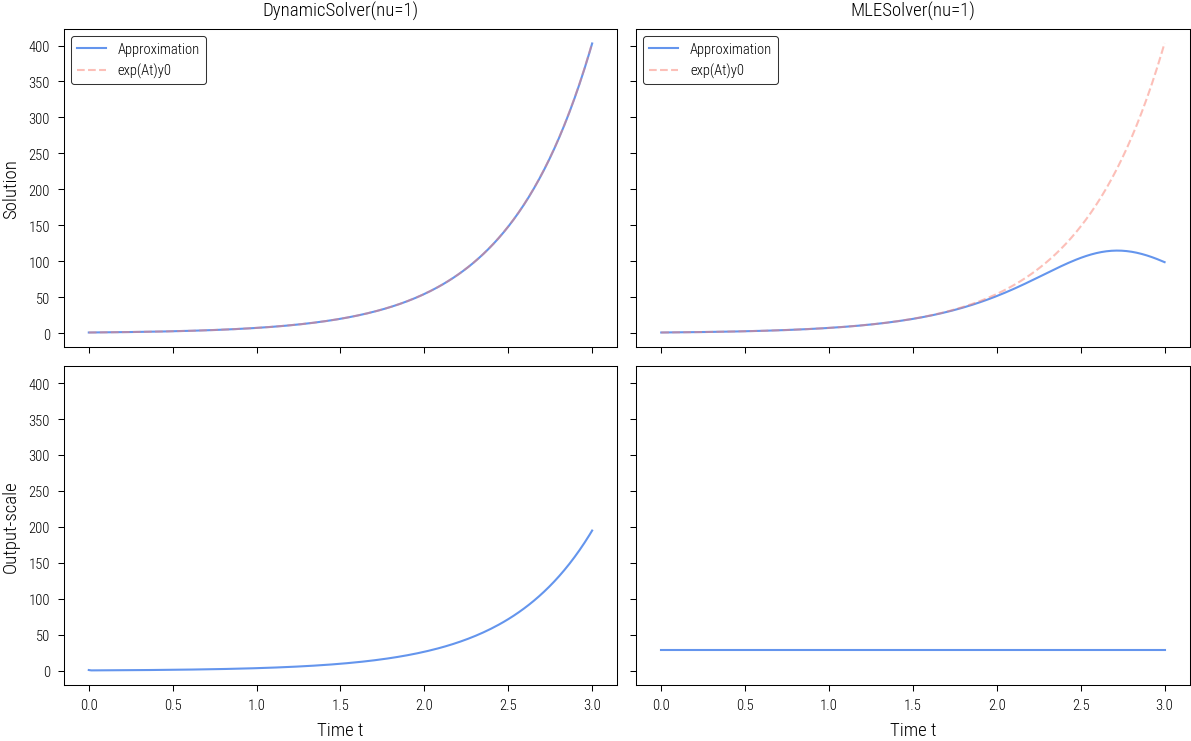

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8, 5))

ax[0][0].plot(ts, solution_dynamic.u, label="Approximation", marker="None")
ax[1][0].plot(ts, solution_dynamic.output_scale_sqrtm, marker="None")
ax[0][1].plot(ts, solution_mle.u, label="Approximation", marker="None")
ax[1][1].plot(ts, solution_mle.output_scale_sqrtm, marker="None")

ax[0][0].plot(
    ts, jnp.exp(ts * 2), alpha=0.5, linestyle="dashed", label="exp(At)y0", marker="None"
)
ax[0][1].plot(
    ts, jnp.exp(ts * 2), alpha=0.5, linestyle="dashed", label="exp(At)y0", marker="None"
)

ax[0][0].legend()
ax[0][1].legend()

ax[0][0].set_title(f"DynamicSolver(nu={num_derivatives})")
ax[0][1].set_title(f"MLESolver(nu={num_derivatives})")
ax[0][0].set_ylabel("Solution")
ax[1][0].set_ylabel("Output-scale")
ax[1][0].set_xlabel("Time t")
ax[1][1].set_xlabel("Time t")
plt.show()

The dynamic solver adapts the output-scale so that both the solution and the output-scale grow exponentially.
The ODE-solution fits the truth well.

The MLESolver does not have this tool, and the ODE solution is not able to follow the exponential: it drifts back to the origin. (This is expected, we are basically trying to fit an exponential with a piecewise polynomial.)

The whole issue gets more pronounced if we increase the time-span. (Careful! We plot in log-scale now.)


In [7]:
t1_long = t1 * 7
num_pts = num_pts * 7
ts = jnp.linspace(t0, t1_long, num=num_pts, endpoint=True)

solution_dynamic = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=dynamic, parameters=f_args
)
solution_mle = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=mle, parameters=f_args
)

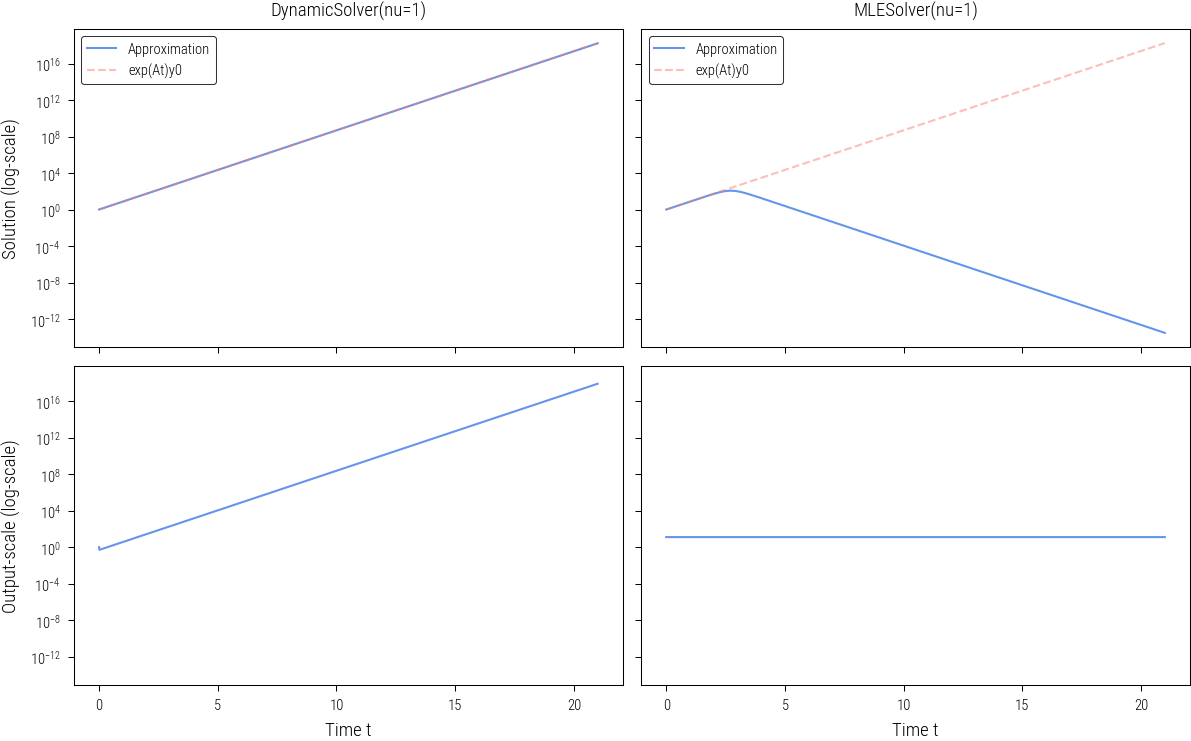

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8, 5))

ax[0][0].semilogy(ts, solution_dynamic.u, label="Approximation", marker="None")
ax[1][0].semilogy(ts, solution_dynamic.output_scale_sqrtm, marker="None")
ax[0][1].semilogy(ts, solution_mle.u, label="Approximation", marker="None")
ax[1][1].semilogy(ts, solution_mle.output_scale_sqrtm, marker="None")

ax[0][0].semilogy(
    ts, jnp.exp(ts * 2), alpha=0.5, linestyle="dashed", label="exp(At)y0", marker="None"
)
ax[0][1].semilogy(
    ts, jnp.exp(ts * 2), alpha=0.5, linestyle="dashed", label="exp(At)y0", marker="None"
)

ax[0][0].legend()
ax[0][1].legend()

ax[0][0].set_title(f"DynamicSolver(nu={num_derivatives})")
ax[0][1].set_title(f"MLESolver(nu={num_derivatives})")
ax[0][0].set_ylabel("Solution (log-scale)")
ax[1][0].set_ylabel("Output-scale (log-scale)")
ax[1][0].set_xlabel("Time t")
ax[1][1].set_xlabel("Time t")
plt.show()

The DynamicSolver follows the exponential growth by rescaling the output-scale appropriately; the MLESolver is hopelessly lost.